<a href="https://colab.research.google.com/github/Ken-Lau-Lab/single-cell-lectures/blob/main/section04_05_dimension_reduction_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Section 4:__ Feature Selection, Dimension Reduction & Clustering

February 22, 2022

---
### __0.__ Import necessary packages and functions

In [ ]:
!git clone git://github.com/Ken-Lau-Lab/single-cell-lectures  # for Colab users
!pip install scanpy  # for Colab users
!pip install leidenalg  # for Colab users
!pip install fa2
!pip install scikit-learn # for Colab users
!cp -r single-cell-lectures/data/ .  # for Colab users

In [1]:
%env PYTHONHASHSEED=0
import scanpy as sc; sc.settings.verbosity = 3  # Set scanpy verbosity to 3 for in depth function run information
import numpy as np
import random; random.seed(22)
from sklearn.preprocessing import normalize
np.random.seed(22)

env: PYTHONHASHSEED=0


---
### __1.__ Preprocessing & Cell Metadata Generation

#### [`AnnData`](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) objects can be read straight from a compressed `.h5ad` file, containing metadata and reduced dimensions.

#### Here, we will read in a manually-filtered `.h5ad` file for our human colonic mucosa data.

In [2]:
adata = sc.read("single-cell-lectures/data/Filtered_TNP_Data.h5ad") ; adata  # for Colab users, path to repository
#adata = sc.read("data/Filtered_TNP_Data.h5ad") ; adata  # for local users, read from data directory

AnnData object with n_obs × n_vars = 2176 × 29426

<img src="data/anndata_schema.svg" alt="anndata_schema" width="500"/>

In [3]:
# this is the shape of the expression matrix, adata.X, which is a numpy array
# note these are all integer values (gene counts)
print(adata.shape)
adata.X

(2176, 29426)


array([[2.987e+03, 0.000e+00, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.854e+03, 0.000e+00, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.688e+03, 1.000e+00, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.500e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.400e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.900e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32)

#### Now we can calculate some quality control (QC) metrics and preprocess the raw counts by __normalizing per cell__ and __arcsinh-transforming__.

In [4]:
# get useful metrics of counts data
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

adata

AnnData object with n_obs × n_vars = 2176 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

#### So we've added a few values to the `.obs` and `.var` pandas dataframes.

#### Now we'll normalize our counts within each cell to adjust for library size, and transform using `arcsinh`, which puts the negative-binomially distributed data in a more digestible dynamic range.

#### **NOTE:** This method is very similar to the popular [log1p](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html), but we prefer `arcsinh` as it better handles small counts values.

In [5]:
# let's first define a custom function that operates on AnnData objects

def arcsinh_norm(adata, layer=None, norm="l1", scale=1000):
    """
    return arcsinh-normalized values for each element in anndata counts matrix
    l1 normalization (sc.pp.normalize_total) should be performed before this transformation
        adata = AnnData object
        layer = name of lauer to perform arcsinh-normalization on. if None, use AnnData.X
        norm = normalization strategy prior to Log2 transform.
            None: do not normalize data
            'l1': divide each count by sum of counts for each cell
            'l2': divide each count by sqrt of sum of squares of counts for cell
        scale = factor to scale normalized counts to; default 1000
    """
    if layer is None:
        mat = adata.X
    else:
        mat = adata.layers[layer]

    adata.layers["arcsinh_norm"] = np.arcsinh(normalize(mat, axis=1, norm=norm) * scale)

In [6]:
# preprocess AnnData for downstream dimensionality reduction
adata.layers["raw_counts"] = adata.X.copy()  # save raw counts in layer
arcsinh_norm(adata, layer="raw_counts", norm="l1", scale=1000)  # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
adata.X = adata.layers["arcsinh_norm"].copy()  # set normalized counts as .X slot in scanpy object

# since we prefer arcsinh over log1p, let's get some arcsinh-transformed metrics as well
adata.obs["arcsinh_total_counts"] = np.arcsinh(adata.obs["total_counts"])
adata.obs["arcsinh_n_genes_by_counts"] = np.arcsinh(adata.obs["n_genes_by_counts"])

# see resulting AnnData contents
adata

AnnData object with n_obs × n_vars = 2176 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [7]:
# now we see that adata.X has arcsinh-transformed values (not integers anymore)
print(adata.shape)
adata.X

(2176, 29426)


array([[4.3154387 , 0.        , 0.06259143, ..., 0.        , 0.        ,
        0.        ],
       [3.861994  , 0.        , 0.0896247 , ..., 0.        , 0.        ,
        0.        ],
       [4.2626843 , 0.0132039 , 0.06597355, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.3758054 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.3445783 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.535373  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

#### We can also do some actual biological stuff now, like quantifying cell cycle genes in our individual cells to determine which populations are actively dividing. 

#### Here we use lists from [Satija et al. (2015), Spatial reconstruction of single-cell gene expression data, Nature Biotechnology.](https://doi.org/10.1038/nbt.3192) to define **S** and **G2M** phase "metagenes", and score them with the `scanpy` function `sc.tl.score_genes_cell_cycle`.

#### We can write another custom function that operates on AnnData objects below to make this easily repeatable:

In [8]:
# define cell cycle phase genes
#  human genes ('_h') from satija lab list
s_genes_h = [
    "MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG",
    "GINS2","MCM6","CDCA7","DTL","PRIM1","UHRF1","MLF1IP",
    "HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76",
    "SLBP","CCNE2","UBR7","POLD3","MSH2","ATAD2","RAD51",
    "RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM","CASP8AP2",
    "USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8",
]
g2m_genes_h = [
    "HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A",
    "NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF",
    "TACC3","FAM64A","SMC4","CCNB2","CKAP2L","CKAP2","AURKB",
    "BUB1","KIF11","ANP32E","TUBB4B","GTSE1","KIF20B","HJURP",
    "CDCA3","HN1","CDC20","TTK","CDC25C","KIF2C","RANGAP1",
    "NCAPD2","DLGAP5","CDCA2","CDCA8","ECT2","KIF23","HMMR",
    "AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF",
    "NEK2","G2E3","GAS2L3","CBX5","CENPA",
]

def cc_score(adata, layer=None, seed=18, verbose=True):
    """
    Calculates cell cycle scores and implied phase for each observation

    Parameters
    ----------

    adata : anndata.AnnData
        object containing transformed and normalized (arcsinh or log1p) counts in 
        'layer'.
    layer : str, optional (default=None)
        key from adata.layers to use for cc phase calculation. Default None to 
        use .X
    seed : int, optional (default=18)
        random state for PCA, neighbors graph and clustering
    verbose : bool, optional (default=True)
        print updates to console

    Returns
    -------

    adata is edited in place to add 'G2M_score', 'S_score', and 'phase' to .obs
    """
    if layer is not None:
        adata.layers["temp"] = adata.X.copy()
        adata.X = adata.layers[layer].copy()
        if verbose:
            print("Calculating cell cycle scores using layer: {}".format(layer))
    else:
        if verbose:
            print("Calculating cell cycle scores")
    # determine if sample is mouse or human based on gene names
    if any(item in adata.var_names for item in s_genes_h + g2m_genes_h):
        s_genes, g2m_genes = s_genes_h, g2m_genes_h
    elif any(item in adata.var_names for item in s_genes_m + g2m_genes_m):
        s_genes, g2m_genes = s_genes_m, g2m_genes_m
    # score cell cycle using scanpy function
    sc.tl.score_genes_cell_cycle(
        adata,
        s_genes=s_genes,  # defined at top of script
        g2m_genes=g2m_genes,  # defined at top of script
        random_state=seed,
    )
    if layer is not None:
        adata.X = adata.layers["temp"].copy()
        del adata.layers["temp"]

In [9]:
# apply our custom function from above
cc_score(adata, layer="arcsinh_norm", seed=18, verbose=True)

calculating cell cycle phase
computing score 'S_score'


Calculating cell cycle scores using layer: arcsinh_norm


    finished: added
    'S_score', score of gene set (adata.obs).
    340 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    427 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


#### Now when we look at our `adata` object, we see new columns `["S_score","G2M_score","phase"]` in `adata.obs` dataframe, describing new cell-level metadata

In [10]:
adata

AnnData object with n_obs × n_vars = 2176 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts', 'S_score', 'G2M_score', 'phase'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

---
### __2.__ Feature Selection

#### Our dataset has almost **30,000 genes**. Thinking about each gene as a "dimension" to our dataset, that puts us at about **10,000 times** as many dimensions as we can comprehend visually (i.e. *x* vs. *y* vs. *z* in a 3D coordinate space).

#### Therefore, we must reduce the dimensionality of our dataset to a low number of "latent" dimensions that describe the overall **similarity between cells** across the entire 30,000-dimension space.

#### **NOTE:** "dimension" = "feature" = "variable" = "gene"; these terms will be used interchangeably.

... storing 'phase' as categorical


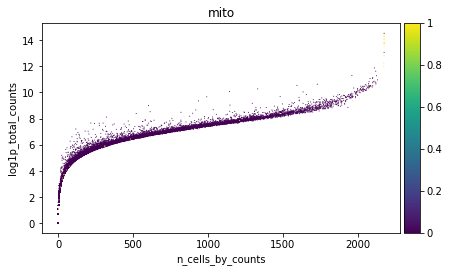

In [11]:
sc.pl.scatter(adata, x="n_cells_by_counts", y="log1p_total_counts", color="mito")

#### If we plot the log-transformed (similar to `arcsinh` for this purpose) total counts for each gene against the number of cells each gene is detected in, we see a large discrepancy in the overall expression **levels** (`log1p_total_counts`) and **frequencies across cells** (`n_cells_by_counts`).

#### We can color this scatterplot by our mitochondrial genes, that we flagged before, and we see that they are **highly expressed** in a **large number of cells**.

#### Next, looking at the `highest_expr_genes` across all cells in our dataset, we also see mitochondrial genes popping up a lot ("MT-").

normalizing counts per cell
    finished (0:00:00)


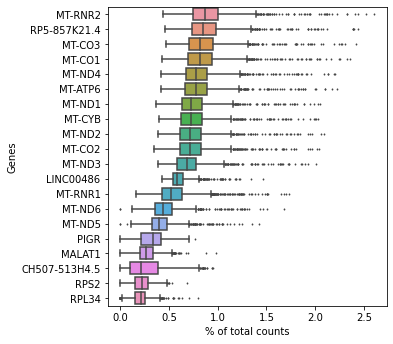

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

#### However, do **highly expressed** genes detected in **all or most cells** provide a lot of information for **distinguishing unique cell populations**?

#### **NO.**  In fact, the best marker genes are **highly expressed in only a small number of cells**, and **not expressed at all** in the rest of the cells. We want our dimension reduction tools (PCA, UMAP, etc. - coming up next) to mostly use good marker genes like this to describe the "latent representation" of our data.

#### Given the description of "good marker genes", what we really want are gene features with **high variance** across all the cells in our dataset.  We can use `sc.pp.highly_variable_genes` to identify "highly variable genes" (HVGs) in our dataset to be used for PCA and downstream analysis.

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


#### `sc.pp.highly_variable_genes` bins the expression of all genes and determines their **dispersion** (fancy word for variance) across the cells in the dataset.

#### Based on the number of genes we want to work with (here we'll go from 30,000 original genes down to 2,000 HVGs), it calculates dispersion cutoffs per expression bin.

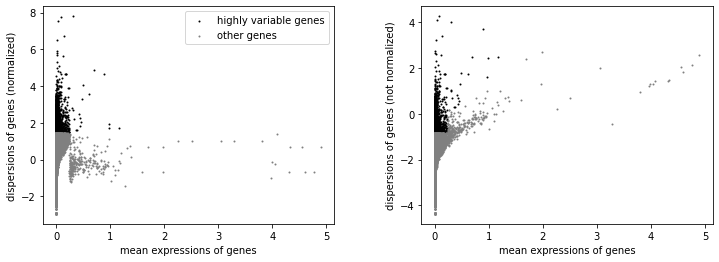

In [14]:
sc.pl.highly_variable_genes(adata)

#### Now we have 2,000 HVGs to work with, and we can effectively "toss out" the "uninformative" genes with low variance for downstream analysis. That's feature selection.

In [15]:
adata.var.highly_variable.value_counts()

False    27426
True      2000
Name: highly_variable, dtype: int64

---
### __3.__ Dimension Reduction

#### Now we can perform an initial dimension reduction with [__principal component analysis (PCA)__](https://en.wikipedia.org/wiki/Principal_component_analysis). This matrix decomposition method creates **linear combinations of native features (genes)** that are **orthogonal to one another** and describe **decreasing amounts of explained variability across datapoints (cells) in native high-dimensional space**. Shown below would be the first two principal components of a 2D Gaussian distribution of points.

<img src="data/gaussianPCA.png" alt="PCA" width="500"/>

#### In simpler terms, PCA provides a standard, linear algebraic transformation of our data in **2,000 HVG space** to a new "principal component space" that better captures **similarities and differences between cells** in a **smaller number of dimensions** (hence, "dimensionality reduction").

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
... storing 'phase' as categorical


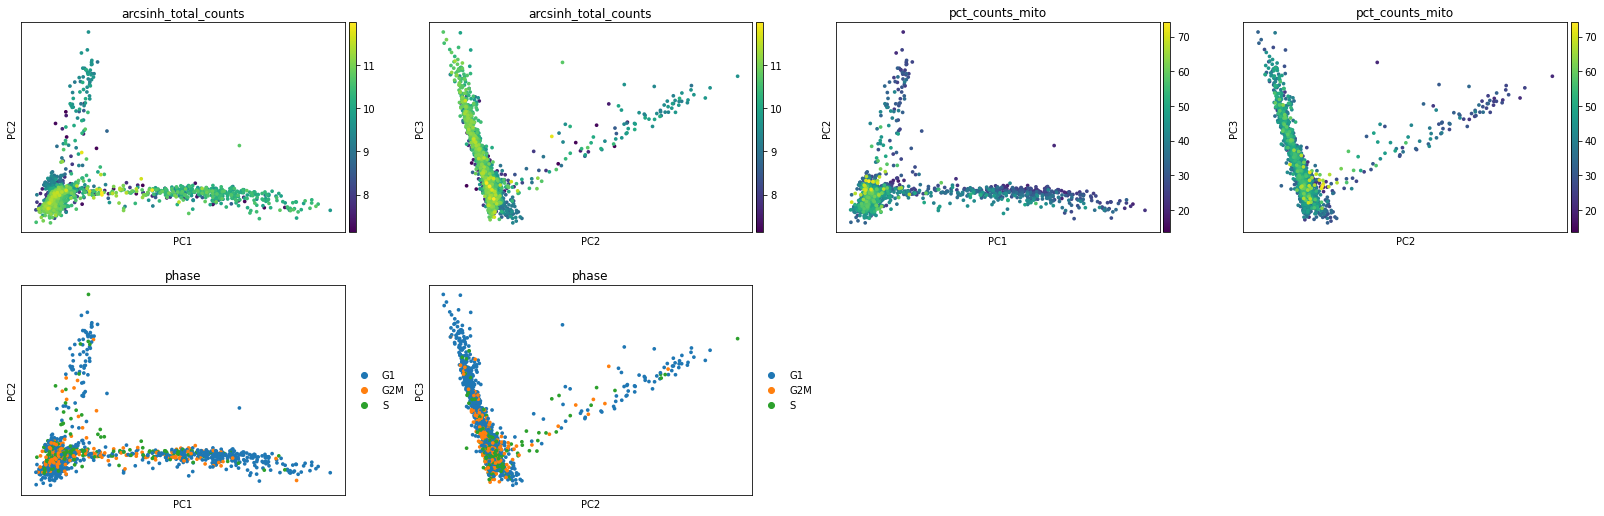

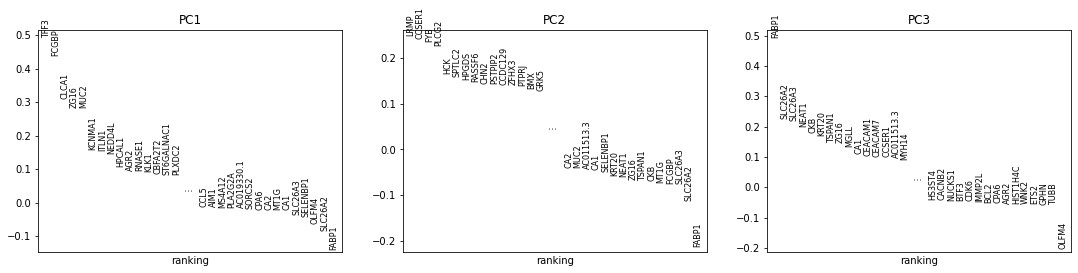

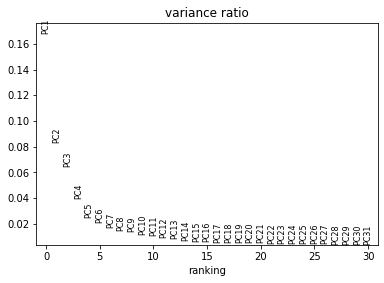

In [16]:
# perform PCA with scanpy tool function
sc.tl.pca(adata, n_comps=50, random_state=0, use_highly_variable=True)  # perform 50-component PCA on our feature-selected dataset

# plot an "overview" of the resulting PCA, including scatterplots, feature loadings, and variance ratios
sc.pl.pca_overview(
    adata,
    components=["1,2","2,3"],
    color=["arcsinh_total_counts","pct_counts_mito","phase"],
    color_map="viridis",
)

#### What we now have is a **dimension-reduced** space with **50 features** (or principal components) that represents the **2,000-gene "latent space"** as a combination of genes. The plots above show us the following (in order):

1. Scatter plot of the **2nd versus 1st PC**, and **3rd versus 2nd PC** for all cells, which we can color by any number of metadata values from `adata.obs` like the total counts in each cell, percentage of mitochondrial counts in each cell, or our previously inferred cell cycle phase.
2. "Loadings" of all our **2,000 input genes** in each PC. This means that cells with **high PC1 values** probably highly express genes *TFF3*, *FCGBP*, and *MUC2*.
3. The variance ratio, or **fraction of total variance explained** by each PC. As you can see, there is an "elbow" around PC10, after which the amount of "information" provided by each PC (read: variance across cells that allow you to tell them apart) significantly drops off. **This means that of our 50 PCs, we can really get the most out of the first 10, and can effectively throw away the other 43 and have almost the same amount of information**!

#### Now we've gone from **30,000 incomprehensible dimensions** down to **ten top principal components** that tell us a whole lot about the cells in our dataset. That's dimension reduction.

---
### __4.__ k-Nearest Neighbors (kNN) Graph & Clustering

#### Next, we'll generate a [__k-nearest neighbors (kNN)__](https://en.wikipedia.org/wiki/Nearest_neighbor_graph) graph that describes similarity between all cells in our dataset based on the above **top 10 PCs**. This graph will be used to perform unsupervised clustering and eventually generate a __UMAP__ embedding.

#### At a high level, a kNN graph just labels the nearest *n* cells to every cell. In a 2D cartesian plane like below, this would easily be done with the pythagorean theorem. We can calculate higher-dimensional [Euclidean distances](https://en.wikipedia.org/wiki/Euclidean_distance) in the same way, this time using our **10-dimensional principal component space**.

<img src="data/nn_graph.jpeg" alt="kNN" width="300"/>

#### We choose the optimal number of nearest neighbors for graph building as the **square-root of the total number of cells** to optimize between **small (local)** and **large (global)** distances in our dataset. This is a commonly-accepted best-practice.

In [17]:
n_neighbs = int(np.sqrt(adata.n_obs))  # determine optimal number of neighbors by sqrt(n_obs)
print("Number of nearest neighbors: {}".format(n_neighbs))

Number of nearest neighbors: 46


#### Using the __PCA__ output above, we can generate a kNN graph and then perform graph-based [__Leiden__ clustering](https://www.nature.com/articles/s41598-019-41695-z/) to determine subpopulations. The Leiden algorithm traverses through the kNN graph and **assigns clusters based on "connectedness" or similarity in the 10-PC space**.

<img src="data/leiden.png" alt="leiden" width="700"/>

In [18]:
sc.pp.neighbors(adata, n_neighbors=n_neighbs, n_pcs=10, random_state=0)  # generate kNN graph with 10 PCs
sc.tl.leiden(adata, resolution=0.5, random_state=1)  # determine dataset clusters

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


#### Now that we have a kNN graph, we can visualize the connections between individual cells using [`sc.tl.draw_graph`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.draw_graph.html) and [`sc.pl.draw_graph`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.draw_graph.html#scanpy.pl.draw_graph). This tool takes the **nodes (cells)** and **edges (connections to nearest neighbors)** and places them in a 2D space by a **"force-directed layout"**. In simple terms, it optimizes the 2D distances between neighbor nodes to be proportional to their distances in high dimensional space (in our case, 10-component PCA) by "pushing" and "pulling" until it converges.

In [19]:
sc.tl.draw_graph(adata, layout="fa", random_state=18)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:06)


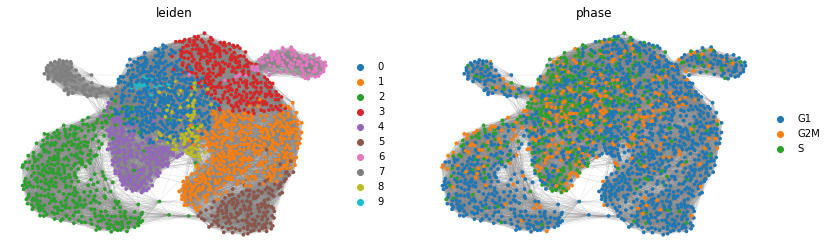

In [20]:
sc.pl.draw_graph(
    adata,
    color=["leiden","phase"],
    edges=True,
    frameon=False,
)  # plot kNN graph. Edge thickness and distance describe cell similarity

#### For the most part, this 2D projection of our kNN graph shows us the major clusters that were identified by the Leiden algorithm.

#### However, further two-dimensional embedding(s) such as **t-distributed stochastic neighbor embedding (t-SNE)** and **uniform manifold approximation and projection (UMAP)** are the industry standard for dataset visualization. 

#### **Why?**

#### Because the true relationships between cells in gene expression space (remember we started with 30,000 gene features) cannot be entirely explained through **linear transformations**. PCA is a linear transformation on our gene expression measurements, and the kNN graph above was built on this linear space. Tools such as t-SNE and UMAP will "project" our data to 2D via **non-linear transformations**, such that both **local and global structure** of our data are preserved more reliably than through linear transformations alone.

#### **Some vocab:**

#### "local structure" = relationships between cells and their close neighbors (here, the 46 nearest cells in PCA)

#### "global structure" = relationships between one large community and the next (here, think of the distance between Leiden clusters)

#### "projection" = "embedding" = 2 or 3 dimensional plot that explains a higher-dimensional structure (UMAP, t-SNE, and `draw_graph` output above)

---
### __5.__ PAGA

#### We'll use [**PAGA**](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x) to generate a coarse-grained graph based on the **Leiden** clusters identified for our dataset. This will be useful in generating initial positions for our [**UMAP**](https://www.nature.com/articles/nbt.4314) embedding, resulting in faster and more reliable optimization than random initialization.

<img src="data/paga.png" alt="leiden" width="700"/>

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


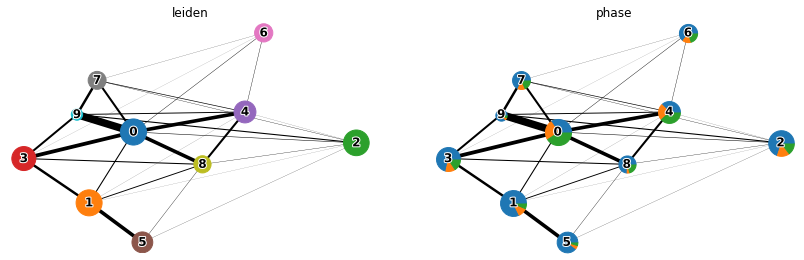

In [22]:
sc.tl.paga(adata)  # PAGA uses the kNN graph and Leiden clusters to create a cluster-cluster similarity graph
sc.pl.paga(
    adata,
    color=["leiden","phase"],
    random_state=18,
    node_size_scale=3,
    fontsize=12,
    fontoutline=2,
    frameon=False,
)  # plot PAGA graph. Edge thickness and distance describe cluster similarity

---
### __5.__ UMAP Embedding

#### Now, we can use **PAGA** positions and the kNN graph generated from 50 principal components to build a two-dimensional [**UMAP**](https://www.nature.com/articles/nbt.4314) embedding.

#### Briefly, UMAP performs a mathematical, iterative optimization problem to place cells in 2D space. This consists of "pushing and pulling" points based on their similarity to one another (defined by kNN graph connections based on PCA distance).

#### Here's an [awesome demonstration](https://pair-code.github.io/understanding-umap/) of how UMAP works.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


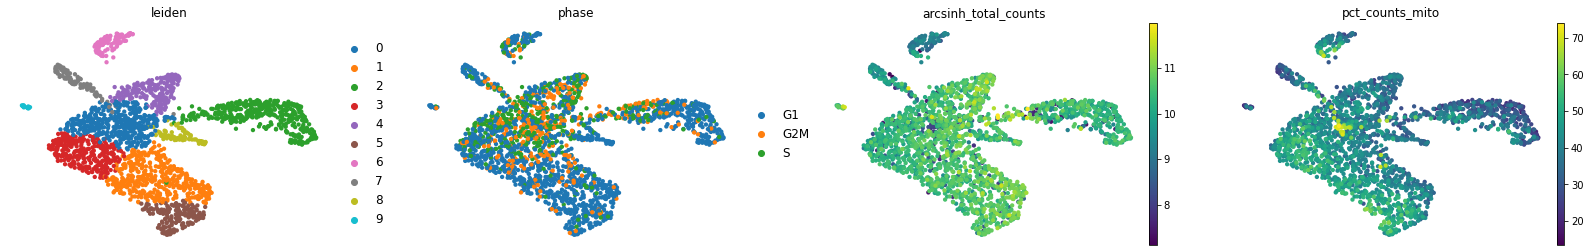

In [23]:
sc.tl.umap(adata, init_pos="paga", random_state=18)  # initialize UMAP with PAGA coordinates
sc.pl.umap(
    adata,
    color=["leiden","phase","arcsinh_total_counts","pct_counts_mito"],
    legend_fontsize=12,
    legend_fontoutline=2,
    size=75,
    frameon=False,
)  # plot embedding with Leiden cluster overlay

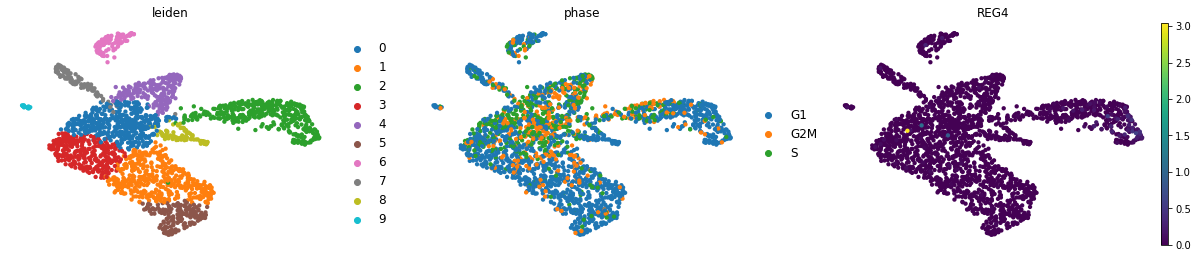

In [29]:
sc.pl.umap(
    adata,
    color=["leiden","phase","REG4"],
    legend_fontsize=12,
    legend_fontoutline=2,
    size=75,
    frameon=False,
)  # plot embedding with Leiden cluster overlay

---
### __6.__ Differential Expression and Cell Type Inference

#### To identify cell types, let's perform __differential expression__ analysis and look at top genes in each cluster. This performs a **t-test** between each cluster and the rest of the cells in the dataset, with **Benjamini-Hochberg** correction for multiple hypothesis testing.

#### We can make a heatmap using `scanpy` of the top **differentially-expressed** genes for each cluster, which will give us a hint as to what type of cells they are.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


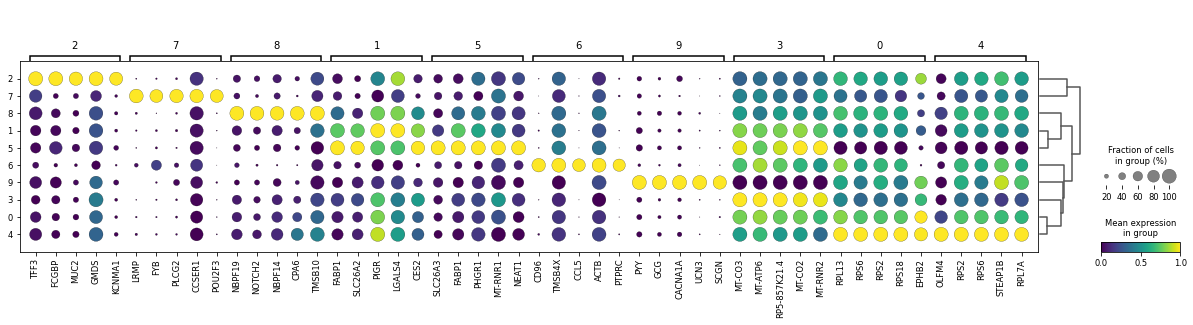

In [24]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, cmap="viridis", standard_scale="var")

#### We can also plot the DE scores for each cluster as a list of the top *n* genes.  Let's look at the top 20.

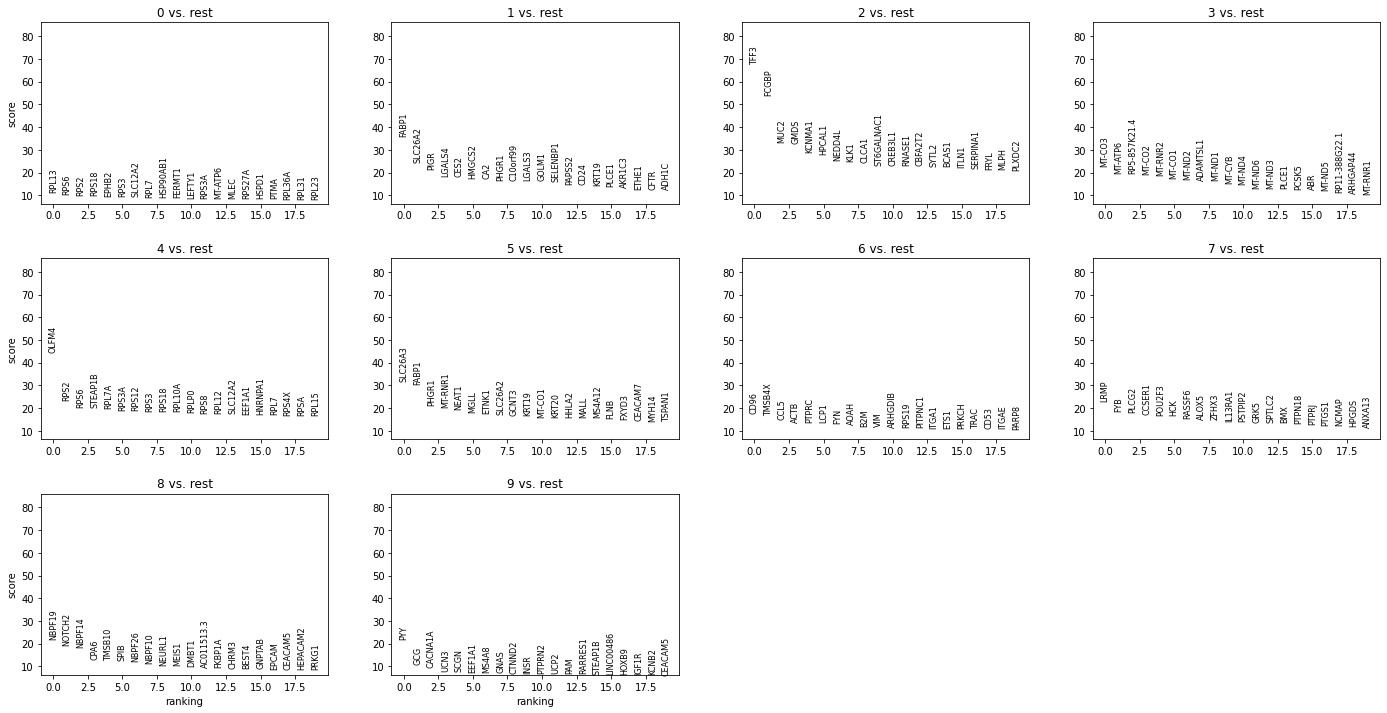

In [26]:
sc.pl.rank_genes_groups(adata, ncols=4, n_genes=20)

#### Now, let's label our clusters by cell type and overlay them on our UMAP embedding.

In [27]:
celltypedict = dict(zip(
    [str(x) for x in range(10)],
    ["Cycling Epi.","Colonocyte","Goblet","Cycling Epi.","Stem","Mature Colonocyte","Lymphocyte","Tuft","Quiescent","Enteroendocrine"]
))

# Remap the values of the dataframe
adata.obs["cell_type"] = adata.obs["leiden"]
adata.obs = adata.obs.replace({"cell_type" : celltypedict})

... storing 'cell_type' as categorical


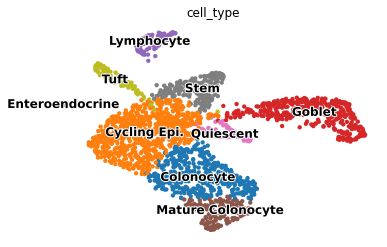

In [28]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    legend_fontsize=12,
    legend_fontoutline=2,
    size=75,
    frameon=False,
    legend_loc="on data",
)  # plot embedding with Leiden cluster overlay